In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [2]:
df = pd.read_csv("Train data.csv")

In [3]:
df.isnull().sum()

author                     1
published                  0
title                      0
text                       0
language                   1
site_url                   1
main_img_url               1
type                       1
title_without_stopwords    3
text_without_stopwords     2
hasImage                   2
label                      1
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df.shape

(1597, 12)

In [6]:
print((df.label == 'Real').sum()) # Real News
print((df.label == 'Fake').sum()) # Fake News

481
1116


In [7]:
#AFTER THE OVERALL OPERATION I DETECT THAT DATA WAS NOT BALANCED SO I HAVE TO SORT WITH CODE BELOW BY RESAMPLING IT AND RETRY THE OPERATION FOR A BETTER ACCURACY
from sklearn.utils import resample
#Creatation of two different dataframe [real and fake]
df_real = df[(df['label']=='Real')]
df_fake = df[(df['label']=='Fake')]
#UNSAMPLING OF THE REAL CLASS SINCE THAT WHERE THE IMBALANCE OCCURS
df_real_unsampled = resample(df_real,
                             replace =True,n_samples=1116)
# COMBINATION OF THE TWO CLASS
df =pd.concat([df_real_unsampled,df_fake])
df['label'].value_counts()


Real    1116
Fake    1116
Name: label, dtype: int64

In [8]:
df['label'] =df['label'].map({'Real':1,'Fake':0}).astype(int)
df['label'].value_counts()


1    1116
0    1116
Name: label, dtype: int64

In [9]:
# Preprocessing
import re
import string

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate/34294022
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
pattern = re.compile(r"https?://(\S+|www)\.\S+")
for t in df.text:
    matches = pattern.findall(t)
    for match in matches:
        #print(t)
        #print(match)
        print(pattern.sub(r"", t))
    if len(matches) > 0:
        break

In [11]:
df["text"] = df.text.map(remove_URL) # map(lambda x: remove_URL(x))
df["text"] = df.text.map(remove_punct)

In [12]:
# remove stopwords
# pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine
# has been programmed to ignore, both when indexing entries for searching and when retrieving them 
# as the result of a search query.
stop = set(stopwords.words("english"))

# https://stackoverflow.com/questions/5486337/how-to-remove-stop-words-using-nltk-or-python
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Simeon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df["text"] = df.text.map(remove_stopwords)

In [15]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.text)

In [16]:
len(counter)

38554

In [17]:
counter.most_common(5)

[('trump', 3917),
 ('clinton', 3409),
 ('said', 2620),
 ('hillary', 2299),
 ('us', 2213)]

In [18]:
num_unique_words = len(counter)

In [19]:
# Split dataset into training and validation set
train_size = int(df.shape[0] * 0.8)

train_df = df[:train_size]
val_df = df[train_size:]

# split text and labels
train_sentences = train_df.text.to_numpy()
train_labels = train_df.label.to_numpy()
val_sentences = val_df.text.to_numpy()
val_labels = val_df.label.to_numpy()

In [20]:
train_sentences.shape, val_sentences.shape

((1785,), (447,))

In [21]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [22]:
# each word has unique index
word_index = tokenizer.word_index

In [23]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [24]:
#print(train_sentences[10:15])
#print(train_sequences[10:15])

In [25]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((1785, 20), (447, 20))

In [26]:
train_padded[10]

array([ 1946,     4,    28,  1779,  2305,    13,  2725,  5279,    49,
          37,   195,     5,     2,  1418,    16,   531, 12771,   201,
        1052,    29])

In [27]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [28]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [62]:
decoded_text = decode(train_sequences[10])

#print(train_sequences[10])
#print(decoded_text)

In [30]:
# Create LSTM model
from tensorflow.keras import layers

# Embedding: https://www.tensorflow.org/tutorials/text/word_embeddings
# Turns positive integers (indexes) into dense vectors of fixed size. (other approach could be one-hot-encoding)

# Word embeddings give us a way to use an efficient, dense representation in which similar words have 
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify).

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.


model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            1233728   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,258,625
Trainable params: 1,258,625
Non-trainable params: 0
_________________________________________________________________


In [32]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [33]:
model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/20
56/56 - 19s - loss: 0.5834 - accuracy: 0.6577 - val_loss: 1.2168 - val_accuracy: 0.6264 - 19s/epoch - 335ms/step
Epoch 2/20
56/56 - 4s - loss: 0.1669 - accuracy: 0.9507 - val_loss: 1.2943 - val_accuracy: 0.5324 - 4s/epoch - 71ms/step
Epoch 3/20
56/56 - 4s - loss: 0.0447 - accuracy: 0.9894 - val_loss: 1.1354 - val_accuracy: 0.7114 - 4s/epoch - 71ms/step
Epoch 4/20
56/56 - 4s - loss: 0.0155 - accuracy: 0.9972 - val_loss: 1.5808 - val_accuracy: 0.6197 - 4s/epoch - 73ms/step
Epoch 5/20
56/56 - 4s - loss: 0.0088 - accuracy: 0.9989 - val_loss: 1.3773 - val_accuracy: 0.6577 - 4s/epoch - 79ms/step
Epoch 6/20
56/56 - 4s - loss: 0.0047 - accuracy: 0.9994 - val_loss: 1.5745 - val_accuracy: 0.6398 - 4s/epoch - 75ms/step
Epoch 7/20
56/56 - 4s - loss: 0.0022 - accuracy: 0.9989 - val_loss: 1.9054 - val_accuracy: 0.6174 - 4s/epoch - 72ms/step
Epoch 8/20
56/56 - 4s - loss: 6.2291e-04 - accuracy: 1.0000 - val_loss: 2.1024 - val_accuracy: 0.6107 - 4s/epoch - 71ms/step
Epoch 9/20
56/56 - 4s - l

In [39]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

56/56 [==============================] - 2s 21ms/step


In [40]:
from sklearn.metrics import confusion_matrix,roc_curve,auc
cm = confusion_matrix(y_true=train_labels, y_pred=predictions)

In [41]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 669    0]
 [   0 1116]]


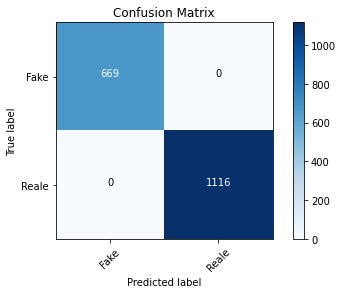

In [42]:
cm_plot_labels = ['Fake','Reale']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

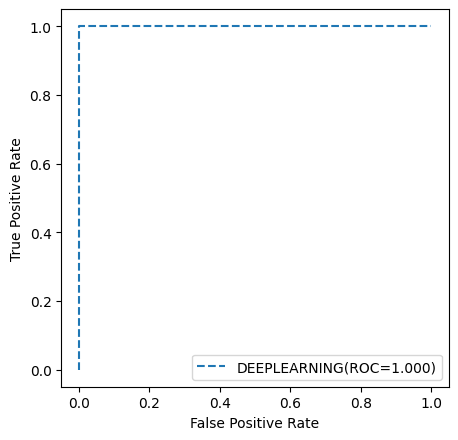

In [43]:
import matplotlib.pyplot as plt
tcl6_fpr,tcl6tpr,threshold = roc_curve(train_labels,predictions)
auc_tcl6 = auc(tcl6_fpr,tcl6tpr)
plt.figure(figsize=(5,5), dpi =100)
plt.plot(tcl6_fpr,tcl6tpr,ls ='--',label ='DEEPLEARNING(ROC=%0.3f)'%auc_tcl6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()